In [2]:
import pandas as pd
import numpy as np
import torch
import torchtext
import os
import re
import spacy
import string
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
import random, copy
import pandas as pd
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

In [14]:
#define function used to detect empty or non-exist file
def check_exist_and_empty(file_path):
    if os.path.isfile(file_path):
        if os.stat(file_path).st_size:
            return True
    print(file_path)
    return False

# Load English tokenizer, tagger, parser, NER and word vectors
spacy_tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def tokenizer(sentence):
    return ' '.join([words.text.lower() for words in spacy_tokenizer(sentence) if words.text not in punctuations])

# Collect all of the movie reviews from the '../aclImdb/train/' into a dataframe
# Collect all of the movie reviews from the '../aclImdb/test/' into another dataframe

In [4]:
train_pos_file_path = '../aclImdb/train/pos/'
train_pos_file_name = [file_name for file_name in os.listdir(train_pos_file_path) if re.findall('^[0-9]+_[0-9]+\.txt$',file_name)]

train_neg_file_path = '../aclImdb/train/neg/'
train_neg_file_name = [file_name for file_name in os.listdir(train_neg_file_path) if re.findall('^[0-9]+_[0-9]+\.txt$',file_name)]

train_pos_file_path_list = [train_pos_file_path + file_path for file_path in train_pos_file_name if check_exist_and_empty(train_pos_file_path + file_path)]
train_neg_file_path_list = [train_neg_file_path + file_path for file_path in train_neg_file_name if check_exist_and_empty(train_neg_file_path + file_path)]

train_dataset = []
for file_path in train_pos_file_path_list:
    train_dataset.append([tokenizer(open(file_path,'r').read()),1])

for file_path in train_neg_file_path_list:
    train_dataset.append([tokenizer(open(file_path,'r').read()),0])



In [55]:
test_pos_file_path = '../aclImdb/test/pos/'
test_pos_file_name = [file_name for file_name in os.listdir(test_pos_file_path) if re.findall('^[0-9]+_[0-9]+\.txt$',file_name)]

test_neg_file_path = '../aclImdb/test/neg/'
test_neg_file_name = [file_name for file_name in os.listdir(test_neg_file_path) if re.findall('^[0-9]+_[0-9]+\.txt$',file_name)]

test_pos_file_path_list = [test_pos_file_path + file_path for file_path in test_pos_file_name if check_exist_and_empty(test_pos_file_path + file_path)]
test_neg_file_path_list = [test_neg_file_path + file_path for file_path in test_neg_file_name if check_exist_and_empty(test_neg_file_path + file_path)]


test_dataset = []
for file_path in test_pos_file_path_list:
    test_dataset.append([tokenizer(open(file_path,'r').read()),1])

for file_path in test_neg_file_path_list:
    test_dataset.append([tokenizer(open(file_path,'r').read()),0])


In [56]:
#pd.DataFrame(train_dataset, columns=['text','label']).to_csv('../aclImdb/data/train.csv',header=False,index=False)
pd.DataFrame(test_dataset, columns=['text','label']).to_csv('../aclImdb/data/test.csv',header=False,index=False)

In [4]:
#train = pd.read_csv('../aclImdb/data/train.csv',header=None)
#test = pd.read_csv('../aclImdb/data/test.csv',header=None)


# 1.BagOfWord model
# 2. Processing_and_BOW class integrates the construction of vocabulary,model training, model selection, and model evaluation. 

In [2]:
class BagOfWord(torch.nn.Module):
    
    def __init__(self, vocab_len, word_vector_dim):
        super().__init__()
        self.word_vector_dim = word_vector_dim
        self.vocab_len = vocab_len
        self.embedding = torch.nn.Embedding(self.vocab_len,self.word_vector_dim)
        self.linear = torch.nn.Linear(self.word_vector_dim,1)
        
    def forward(self,X):
        sentence_length = (X>1).sum(0).unsqueeze(dim=1)
        sentence_length[sentence_length < 1] = 1
        sentence_length = sentence_length.float().cuda()
        X = self.embedding(X)
        X = X.sum(dim = 0)
        X = X/sentence_length
        out = self.linear(X)
        return torch.nn.functional.sigmoid(out.squeeze())
    
    

class Processing_and_BOW():
    
    def __init__(self, bow, optimizer, learning_rate, scheduler, decay_rate, batch_size = 32 ,n_gram=1, min_freq = 1, embedding_dim = 100, 
                 train_file_path = '../aclImdb/data/train.csv', test_file_path= '../aclImdb/data/test.csv', weight_decay = 0.0, 
                 max_epoch = 50, early_stopping_rounds = 5):
        
        self.model = bow
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.scheduler = scheduler
        self.decay_rate = decay_rate
        self.n_gram = n_gram
        self.min_freq = min_freq
        self.embedding_dim = embedding_dim
        self.train_file_path = train_file_path
        self.test_file_path = test_file_path
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.max_epoch = max_epoch
        self.early_stopping_rounds = early_stopping_rounds
        self.error_track = []
        self.right_track = []
        
        if self.optimizer == torch.optim.Adam:
            self.optimizer_name = 'Adam'
        elif self.optimizer == torch.optim.Adagrad:
            self.optimizer_name = 'Adagrad'
        else:
            self.optimizer_name = 'Unknown'
        
        print(' Parameters  n_gram: ',self.n_gram, ' embedding_dim: ', self.embedding_dim, ' min_freq:', self.min_freq, ' batch_size: ', self.batch_size,
              ' optimizer_name: ', self.optimizer_name, ' learning rate: ', self.learning_rate, ' decay_rate: ', self.decay_rate, ' weight_decay:', self.weight_decay)
        
        
    def n_bag_of_word(self, x):
        if len(x) <= self.n_gram:
            return [tuple(x)]
        else:
            result = []
            for i in range(0,len(x) - self.n_gram + 1):
                result.append(tuple(x[i:i+self.n_gram]))
            return result
    
    
    def process_file_and_get_vocab(self):
        TEXT = torchtext.data.Field(preprocessing = self.n_bag_of_word)
        LABEL = torchtext.data.Field(sequential = False, use_vocab = False)
        
        TEST_TEXT = torchtext.data.Field(preprocessing = self.n_bag_of_word)
        TEST_LABEL = torchtext.data.Field(sequential = False, use_vocab = False)
        
        self.train,self.validation = torchtext.data.TabularDataset(self.train_file_path,format='csv',
                              fields=[('text',TEXT),('label',LABEL)]).split(split_ratio=0.8, stratified=True,
                                                                            strata_field='label', 
                                                                            random_state= random.getstate())
        
        self.test = torchtext.data.TabularDataset(self.test_file_path,format='csv',
                              fields=[('text',TEST_TEXT),('label',TEST_LABEL)])
        
        TEXT.build_vocab(self.train,min_freq=self.min_freq)
        TEST_TEXT.vocab = TEXT.vocab
        
        
        self.train_iter = torchtext.data.BucketIterator(self.train, batch_size=self.batch_size, sort_key = lambda x: len(x.Text),
                                                       repeat=False, shuffle=True, device=0)
        self.validation_iter = torchtext.data.BucketIterator(self.validation, batch_size=self.batch_size, sort_key = lambda x: len(x.Text),
                                                       repeat=False, shuffle=True, device=0)
        self.test_iter = torchtext.data.BucketIterator(self.test, batch_size=self.batch_size, sort_key = lambda x: len(x.Text),
                                                       repeat=False, shuffle=True, device=0)
        
        print('The number of reviews in train: ', len(self.train.examples))
        print('The number of reviews in validation: ', len(self.validation.examples))
        print('The number of reviews in test: ', len(self.test.examples))
        self.vocab_size = len(self.train.fields['text'].vocab.itos)
        print('The vocab size: ', self.vocab_size)
        print('The top ten most frequent words: ')
        print(sorted(self.train.fields['text'].vocab.freqs.items(), key= lambda a : a[1], reverse=True)[:20])
        
    
    
    def init_model_and_optimizer(self):
        self.model = self.model(vocab_len = len(self.train.fields['text'].vocab.itos),
                                word_vector_dim = self.embedding_dim).cuda()
        self.optimizer = self.optimizer([p for p in self.model.parameters() if p.requires_grad], lr = self.learning_rate, 
                                        weight_decay = self.weight_decay)
        self.scheduler = self.scheduler(self.optimizer, lambda epoch: self.decay_rate ** epoch)
    
    
    
    def train_model(self):
        self.model.train()
        for batch in self.train_iter:
            self.optimizer.zero_grad()
            text,label = batch.text,batch.label.float().cuda()
            out = self.model(text)
            loss = torch.nn.functional.binary_cross_entropy(out, label)
            loss.backward()
            self.optimizer.step()
    
    
    
    
    def eval_model(self,model,data_iter, show_erro = False, show_figure = False):
        
        model.eval()
        predict = []
        target = []
        num_wrong_record = 0
        num_right_record = 0
        
        for batch in data_iter:
            text,label = batch.text,batch.label
            current_predict = list(model(text).cpu().detach().numpy())
            predict.extend(current_predict)
            current_target = list(label.cpu().detach().numpy())
            target.extend(current_target)
            if show_erro:
                current_predict = [int(p>=0.5) for p in current_predict]
                mask = [int(current_target[i]) != int(current_predict[i]) for i in range(len(current_target))]
                if num_wrong_record < 20:
                    self.error_track.append((text[:,torch.tensor(mask)], np.array(current_target)[mask]))
                    num_wrong_record += sum(np.array(mask))
                if num_right_record < 10:
                    self.right_track.append((text[:,~torch.tensor(mask)], np.array(current_target)[~np.array(mask)]))
                    num_right_record += sum(~np.array(mask))
            
            
        predict_int = [int(p>=0.5) for p in predict]
        accuracy_rate = accuracy_score(target,predict_int)
        
        if show_figure:
            fpr, tpr, thresholds = roc_curve(target, predict, pos_label=1)
            lw=2
            f, (ax1, ax2) = plt.subplots(1, 2)
            f.set_figheight(5)
            f.set_figwidth(10)
            ax1.plot(fpr,tpr)
            ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            ax1.set_xlim([0.0, 1.0])
            ax1.set_ylim([0.0, 1.05])
            ax1.set_title('AUC on test dataset')
            cnf_matrix = confusion_matrix(target, predict_int)
            
            self.plot_confusion_matrix(cnf_matrix, ['Negative','Positive'], ax2, normalize = True,
                                  title='Confusion matrix')

        
        return accuracy_rate,roc_auc_score(target, predict)
        
    
    def train_and_select_model(self):
        print('---------------------Accuracy rate and AUC on validation dataset-------------------- ')
        accuracy_rate_val, auc_val = self.eval_model(self.model, self.validation_iter)
        accuracy_rate_train, auc_train = self.eval_model(self.model, self.train_iter)
        print('Before training  accuracy_rate: ',accuracy_rate_val, ' AUC: ', auc_val)
        self.eval_on_val_accuracy_rate = [accuracy_rate_val]
        self.eval_on_val_auc = [auc_val]
        
        self.eval_on_train_accuracy_rate = [accuracy_rate_train]
        self.eval_on_train_auc = [auc_train]
        best_accuracy = 0.0
        best_epoch = -1
        for epoch in range(self.max_epoch):
            self.scheduler.step()
            self.train_model()
            
            accuracy_rate_val, auc_val = self.eval_model(self.model, self.validation_iter)
            self.eval_on_val_accuracy_rate.append(accuracy_rate_val)
            self.eval_on_val_auc.append(auc_val)
            
            accuracy_rate_train, auc_train = self.eval_model(self.model, self.train_iter)
            self.eval_on_train_accuracy_rate.append(accuracy_rate_train)
            self.eval_on_train_auc.append(auc_train)
            
            print(epoch,' accuracy_rate: ', accuracy_rate_val, ' auc: ', auc_val)
            if accuracy_rate_val > best_accuracy:
                self.best_model = copy.deepcopy(self.model)
                best_accuracy = accuracy_rate_val
                best_epoch = epoch
            if epoch - best_epoch > self.early_stopping_rounds:
                break
        self.best_epoch = best_epoch
        print('Training process end, the best model was picked when epoch = ', best_epoch, '''with the best
         accuracy rate on validation dataset: ''',best_accuracy) 
        
            
    def plot_confusion_matrix(self, cm, classes,ax2,
                          normalize=False,
                          title='Confusion matrix on Test dataset',
                          cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


        img = ax2.imshow(cm, interpolation='nearest', cmap=cmap)
        ax2.set_title(title)
        plt.colorbar(img)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax2.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        ax2.set_ylabel('True label')
        ax2.set_xlabel('Predicted label')
        plt.tight_layout()
        plt.show()
    
    
    def plot_training_curve(self):
            plt.plot(self.eval_on_val_accuracy_rate, label = 'accuracy rate on validation')
            plt.plot(self.eval_on_train_accuracy_rate, label = 'accuracy rate on train')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy rate')
            plt.title('Training curve')
            plt.legend()
            plt.show()
    
    def eval_on_test_data(self):
        print('--------------------------Evaluation of Test set------------------------------')
        accuracy_rate,auc = self.eval_model(self.best_model, self.test_iter, show_erro=True, show_figure=True)
        print('On test dataset: accuracy_rate: ',accuracy_rate, ' AUC: ', auc)
        return accuracy_rate, auc
    
    def show_result_text(self):
        print('--------------------------3 correct and 3 incorrect predictions------------------------------')
        self.misclassified_text = self.retrieve_text(self.error_track)
        self.rightclassified_text = self.retrieve_text(self.right_track)
        
        
    def retrieve_text(self, track):
        classified_text = []
        for error_batch in track:
            text_batch, target_batch = error_batch
            if text_batch.shape[0] > 0:
                for i in range(text_batch.shape[1]):
                    text_indices, label = text_batch[:,i], target_batch[i]
                    text = ' '.join([self.train.fields['text'].vocab.itos[index][0] for index in text_indices]).replace('<','').strip()
                    classified_text.append((text, label))
        return classified_text
        

# GridSearch

Doesn't show all result of all of the combination of parameters due to space limitation

In [3]:
n_gram_list = [1]
optimizer_list = [torch.optim.Adam]
embedding_dim_list = [30, 50, 100, 150]
min_freq_list = [1, 10, 20, 30]
learning_rate_list = [0.005]
decay_rate_list = [0.9]
batch_size_list = [32]
weight_decay_list = [0.0]

 Parameters  n_gram:  1  embedding_dim:  30  min_freq: 1  batch_size:  32  optimizer_name:  Adam  learning rate:  0.005  decay_rate:  0.9  weight_decay: 0.0
The number of reviews in train:  20000
The number of reviews in validation:  5000
The number of reviews in test:  25000
The vocab size:  91056
The top ten most frequent words: 
[(('the',), 263012), (('and',), 130382), (('a',), 129418), (('of',), 116456), (('to',), 108171), (('is',), 87888), (('it',), 74640), (('in',), 74214), (('i',), 66068), (('this',), 58829), (('that',), 58219), (("'s",), 49506), (('was',), 40506), (('/><br',), 40316), (('as',), 36809), (('with',), 35218), (('for',), 35182), (('movie',), 34400), (('but',), 33268), (('film',), 31616)]
---------------------Accuracy rate and AUC on validation dataset-------------------- 
Before training  accuracy_rate:  0.505  AUC:  0.49170616
0  accuracy_rate:  0.5754  auc:  0.7130932799999999
1  accuracy_rate:  0.6936  auc:  0.8250202400000001
2  accuracy_rate:  0.854  auc:  0.91

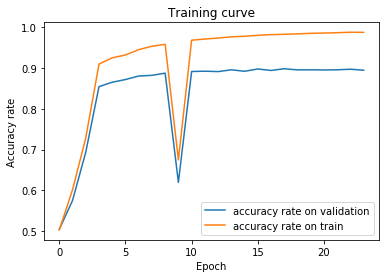

--------------------------Evaluation of Test set------------------------------


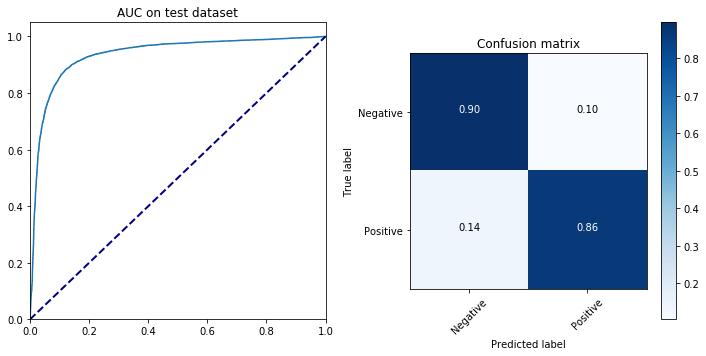

On test dataset: accuracy_rate:  0.87984  AUC:  0.9354933855999998
--------------------------3 correct and 3 incorrect predictions------------------------------
---------3 correct prediction -------
[("solomon and sheba has come down in hollywood lore not for the quality of the film but for the fact that tyrone power died while making it i was in the 5th grade and well remember the huge news for days when that tragedy happened i did n't know who tyrone power was then but i learned and learned to appreciate the body of his work.br />br />i often wonder if ty had a sense about this film and what a dud it proved he was the unnamed producer of this as well maybe he just did n't want to face the critics good thing power actually went out with witness for the prosecution although you can see him in long shots if you look close br />br />what we have here is a biblical stew that probably would baffle the great solomon himself several incidents described in the bible that the bible treats sepa

The number of reviews in train:  20000
The number of reviews in validation:  5000
The number of reviews in test:  25000
The vocab size:  18705
The top ten most frequent words: 
[(('the',), 263012), (('and',), 130382), (('a',), 129418), (('of',), 116456), (('to',), 108171), (('is',), 87888), (('it',), 74640), (('in',), 74214), (('i',), 66068), (('this',), 58829), (('that',), 58219), (("'s",), 49506), (('was',), 40506), (('/><br',), 40316), (('as',), 36809), (('with',), 35218), (('for',), 35182), (('movie',), 34400), (('but',), 33268), (('film',), 31616)]
---------------------Accuracy rate and AUC on validation dataset-------------------- 
Before training  accuracy_rate:  0.4994  AUC:  0.47708424
0  accuracy_rate:  0.574  auc:  0.70238784
1  accuracy_rate:  0.8344  auc:  0.9068210400000001
2  accuracy_rate:  0.8592  auc:  0.92294664
3  accuracy_rate:  0.8508  auc:  0.92776864
4  accuracy_rate:  0.8764  auc:  0.9358097599999999
5  accuracy_rate:  0.8788  auc:  0.9396908
6  accuracy_rate: 

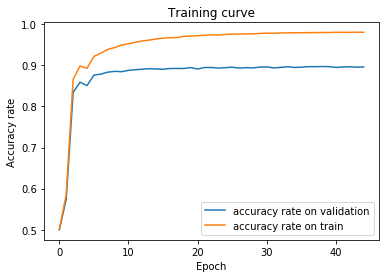

--------------------------Evaluation of Test set------------------------------


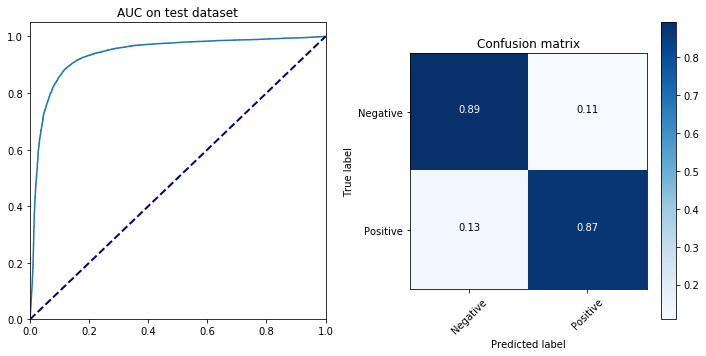

On test dataset: accuracy_rate:  0.88124  AUC:  0.9381834688
--------------------------3 correct and 3 incorrect predictions------------------------------
---------3 correct prediction -------
[("there are many so called anti war anti  policy films around now which start off as a   and end with our poor boys are getting hell out there so let the world sympathise with them it 's not their fault kind of stuff i was half afraid that this would be another in that style even if it treated another subject aspect of the same subject i nearly did n't go and see it for that matter i almost did not write this review what did we get here an egyptian gets taken off to a secret off shore torture centre on u.s. orders but it is another egyptian who has to do the torturing not an american see we americans have clean hands and the  are a bad lot anyway so let them harm their own oh and the goody had to be an american with a conscience indeed many americans have them but here the concept was misplaced 

The number of reviews in train:  20000
The number of reviews in validation:  5000
The number of reviews in test:  25000
The vocab size:  11959
The top ten most frequent words: 
[(('the',), 263012), (('and',), 130382), (('a',), 129418), (('of',), 116456), (('to',), 108171), (('is',), 87888), (('it',), 74640), (('in',), 74214), (('i',), 66068), (('this',), 58829), (('that',), 58219), (("'s",), 49506), (('was',), 40506), (('/><br',), 40316), (('as',), 36809), (('with',), 35218), (('for',), 35182), (('movie',), 34400), (('but',), 33268), (('film',), 31616)]
---------------------Accuracy rate and AUC on validation dataset-------------------- 
Before training  accuracy_rate:  0.4956  AUC:  0.50706048
0  accuracy_rate:  0.71  auc:  0.78631016
1  accuracy_rate:  0.8256  auc:  0.8965273600000001
2  accuracy_rate:  0.8502  auc:  0.91731144
3  accuracy_rate:  0.8638  auc:  0.92634792
4  accuracy_rate:  0.8684  auc:  0.92960928
5  accuracy_rate:  0.8748  auc:  0.9350793599999998
6  accuracy_rate: 

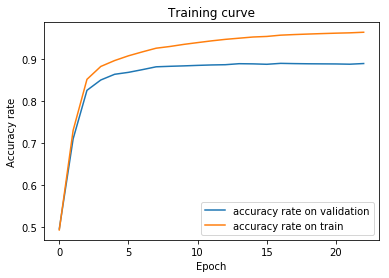

--------------------------Evaluation of Test set------------------------------


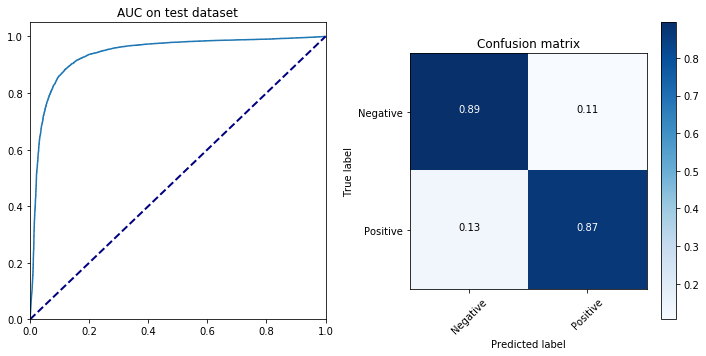

On test dataset: accuracy_rate:  0.88108  AUC:  0.9386605344
--------------------------3 correct and 3 incorrect predictions------------------------------
---------3 correct prediction -------
[("there are many so called anti war anti  policy films around now which start off as a   and end with our poor boys are getting hell out there so let the world  with them it 's not their fault kind of stuff i was half afraid that this would be another in that style even if it treated another subject aspect of the same subject i nearly did n't go and see it for that matter i almost did not write this review what did we get here an egyptian gets taken off to a secret off shore torture centre on u.s. orders but it is another egyptian who has to do the torturing not an american see we americans have clean hands and the  are a bad lot anyway so let them harm their own oh and the  had to be an american with a conscience indeed many americans have them but here the concept was misplaced yes we all know

The number of reviews in train:  20000
The number of reviews in validation:  5000
The number of reviews in test:  25000
The vocab size:  9076
The top ten most frequent words: 
[(('the',), 263012), (('and',), 130382), (('a',), 129418), (('of',), 116456), (('to',), 108171), (('is',), 87888), (('it',), 74640), (('in',), 74214), (('i',), 66068), (('this',), 58829), (('that',), 58219), (("'s",), 49506), (('was',), 40506), (('/><br',), 40316), (('as',), 36809), (('with',), 35218), (('for',), 35182), (('movie',), 34400), (('but',), 33268), (('film',), 31616)]
---------------------Accuracy rate and AUC on validation dataset-------------------- 
Before training  accuracy_rate:  0.502  AUC:  0.50943488
0  accuracy_rate:  0.7604  auc:  0.8649068799999999
1  accuracy_rate:  0.813  auc:  0.87880864
2  accuracy_rate:  0.8486  auc:  0.9134848
3  accuracy_rate:  0.8488  auc:  0.91978072
4  accuracy_rate:  0.8626  auc:  0.9276027199999999
5  accuracy_rate:  0.8558  auc:  0.92469272
6  accuracy_rate:  0

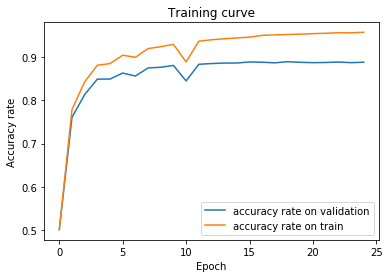

--------------------------Evaluation of Test set------------------------------


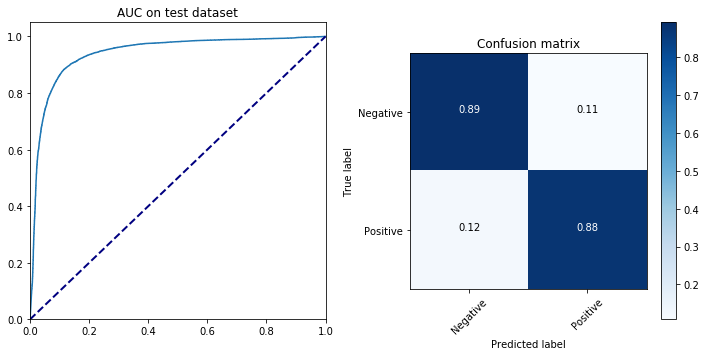

On test dataset: accuracy_rate:  0.88364  AUC:  0.9400635552
--------------------------3 correct and 3 incorrect predictions------------------------------
---------3 correct prediction -------
[("and  has come down in hollywood  not for the quality of the film but for the fact that  power died while making it i was in the  grade and well remember the huge news for days when that tragedy happened i did n't know who  power was then but i learned and learned to appreciate the body of his work.br />br />i often wonder if  had a sense about this film and what a dud it proved he was the  producer of this as well maybe he just did n't want to face the critics good thing power actually went out with witness for the  although you can see him in long shots if you look close br />br />what we have here is a biblical  that probably would  the great  himself several incidents described in the bible that the bible treats  are  together into one plot with a few  tossed in by hollywood br />br />the a

The number of reviews in train:  20000
The number of reviews in validation:  5000
The number of reviews in test:  25000
The vocab size:  91056
The top ten most frequent words: 
[(('the',), 263012), (('and',), 130382), (('a',), 129418), (('of',), 116456), (('to',), 108171), (('is',), 87888), (('it',), 74640), (('in',), 74214), (('i',), 66068), (('this',), 58829), (('that',), 58219), (("'s",), 49506), (('was',), 40506), (('/><br',), 40316), (('as',), 36809), (('with',), 35218), (('for',), 35182), (('movie',), 34400), (('but',), 33268), (('film',), 31616)]
---------------------Accuracy rate and AUC on validation dataset-------------------- 
Before training  accuracy_rate:  0.5004  AUC:  0.51066232
0  accuracy_rate:  0.536  auc:  0.60982048
1  accuracy_rate:  0.8122  auc:  0.90144064
2  accuracy_rate:  0.8686  auc:  0.9279324
3  accuracy_rate:  0.8666  auc:  0.9333768
4  accuracy_rate:  0.8842  auc:  0.93826096
5  accuracy_rate:  0.8882  auc:  0.94155384
6  accuracy_rate:  0.8906  auc:  0.

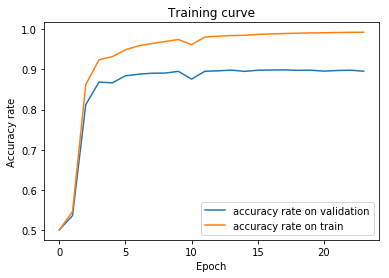

--------------------------Evaluation of Test set------------------------------


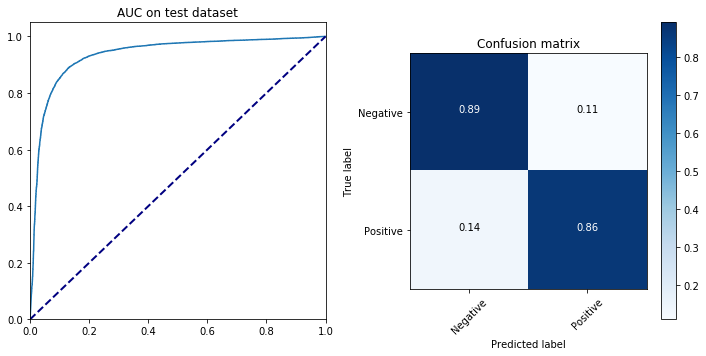

On test dataset: accuracy_rate:  0.8776  AUC:  0.9352232704
--------------------------3 correct and 3 incorrect predictions------------------------------
---------3 correct prediction -------
[("there are many so called anti war anti govt policy films around now which start off as a mea  and end with our poor boys are getting hell out there so let the world sympathise with them it 's not their fault kind of stuff i was half afraid that this would be another in that style even if it treated another subject aspect of the same subject i nearly did n't go and see it for that matter i almost did not write this review what did we get here an egyptian gets taken off to a secret off shore torture centre on u.s. orders but it is another egyptian who has to do the torturing not an american see we americans have clean hands and the egyptians are a bad lot anyway so let them harm their own oh and the goody had to be an american with a conscience indeed many americans have them but here the concept

The number of reviews in train:  20000
The number of reviews in validation:  5000
The number of reviews in test:  25000
The vocab size:  18705
The top ten most frequent words: 
[(('the',), 263012), (('and',), 130382), (('a',), 129418), (('of',), 116456), (('to',), 108171), (('is',), 87888), (('it',), 74640), (('in',), 74214), (('i',), 66068), (('this',), 58829), (('that',), 58219), (("'s",), 49506), (('was',), 40506), (('/><br',), 40316), (('as',), 36809), (('with',), 35218), (('for',), 35182), (('movie',), 34400), (('but',), 33268), (('film',), 31616)]
---------------------Accuracy rate and AUC on validation dataset-------------------- 
Before training  accuracy_rate:  0.4988  AUC:  0.48452544000000003
0  accuracy_rate:  0.531  auc:  0.65973024
1  accuracy_rate:  0.773  auc:  0.8990676
2  accuracy_rate:  0.8552  auc:  0.92343928
3  accuracy_rate:  0.8432  auc:  0.9277078400000001
4  accuracy_rate:  0.8836  auc:  0.9404389599999999
5  accuracy_rate:  0.8852  auc:  0.94221696
6  accurac

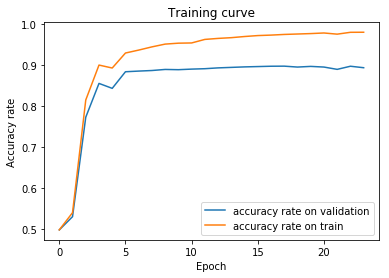

--------------------------Evaluation of Test set------------------------------


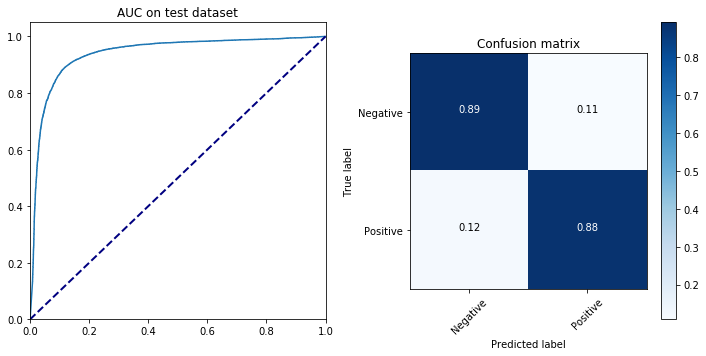

On test dataset: accuracy_rate:  0.88592  AUC:  0.9397892319999999
--------------------------3 correct and 3 incorrect predictions------------------------------
---------3 correct prediction -------
[("there are many so called anti war anti  policy films around now which start off as a   and end with our poor boys are getting hell out there so let the world sympathise with them it 's not their fault kind of stuff i was half afraid that this would be another in that style even if it treated another subject aspect of the same subject i nearly did n't go and see it for that matter i almost did not write this review what did we get here an egyptian gets taken off to a secret off shore torture centre on u.s. orders but it is another egyptian who has to do the torturing not an american see we americans have clean hands and the  are a bad lot anyway so let them harm their own oh and the goody had to be an american with a conscience indeed many americans have them but here the concept was misp

The number of reviews in train:  20000
The number of reviews in validation:  5000
The number of reviews in test:  25000
The vocab size:  11959
The top ten most frequent words: 
[(('the',), 263012), (('and',), 130382), (('a',), 129418), (('of',), 116456), (('to',), 108171), (('is',), 87888), (('it',), 74640), (('in',), 74214), (('i',), 66068), (('this',), 58829), (('that',), 58219), (("'s",), 49506), (('was',), 40506), (('/><br',), 40316), (('as',), 36809), (('with',), 35218), (('for',), 35182), (('movie',), 34400), (('but',), 33268), (('film',), 31616)]
---------------------Accuracy rate and AUC on validation dataset-------------------- 
Before training  accuracy_rate:  0.5  AUC:  0.53325856
0  accuracy_rate:  0.6238  auc:  0.7000107999999999
1  accuracy_rate:  0.8398  auc:  0.9151231200000001
2  accuracy_rate:  0.8644  auc:  0.9279164000000001
3  accuracy_rate:  0.8616  auc:  0.93413928
4  accuracy_rate:  0.8774  auc:  0.9348612
5  accuracy_rate:  0.8828  auc:  0.94014816
6  accuracy_

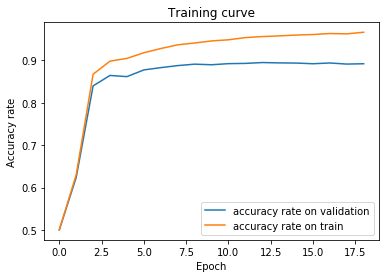

--------------------------Evaluation of Test set------------------------------


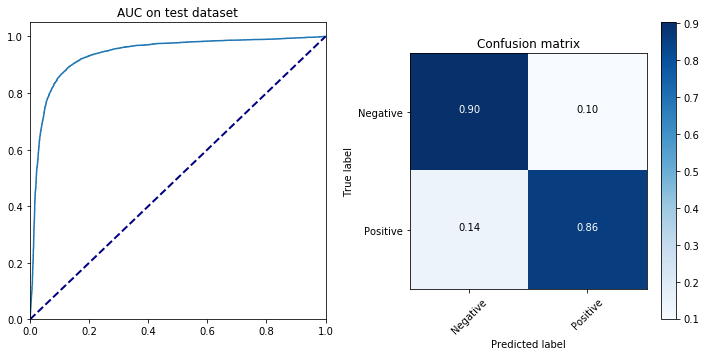

On test dataset: accuracy_rate:  0.87944  AUC:  0.9377562624
--------------------------3 correct and 3 incorrect predictions------------------------------
---------3 correct prediction -------
[("and  has come down in hollywood lore not for the quality of the film but for the fact that  power died while making it i was in the 5th grade and well remember the huge news for days when that tragedy happened i did n't know who  power was then but i learned and learned to appreciate the body of his work.br />br />i often wonder if  had a sense about this film and what a dud it proved he was the unnamed producer of this as well maybe he just did n't want to face the critics good thing power actually went out with witness for the  although you can see him in long shots if you look close br />br />what we have here is a biblical  that probably would  the great  himself several incidents described in the bible that the bible treats  are woven together into one plot with a few additions tossed in 

The number of reviews in train:  20000
The number of reviews in validation:  5000
The number of reviews in test:  25000
The vocab size:  9076
The top ten most frequent words: 
[(('the',), 263012), (('and',), 130382), (('a',), 129418), (('of',), 116456), (('to',), 108171), (('is',), 87888), (('it',), 74640), (('in',), 74214), (('i',), 66068), (('this',), 58829), (('that',), 58219), (("'s",), 49506), (('was',), 40506), (('/><br',), 40316), (('as',), 36809), (('with',), 35218), (('for',), 35182), (('movie',), 34400), (('but',), 33268), (('film',), 31616)]
---------------------Accuracy rate and AUC on validation dataset-------------------- 
Before training  accuracy_rate:  0.5068  AUC:  0.49609303999999993
0  accuracy_rate:  0.7348  auc:  0.8197922399999998
1  accuracy_rate:  0.835  auc:  0.9069053600000001


KeyboardInterrupt: 

In [4]:
result = []
for n_gram in n_gram_list:
    for optimizer in optimizer_list:
        for embedding_dim in embedding_dim_list:
            for min_freq in min_freq_list:
                for learning_rate in learning_rate_list:
                    for decay_rate in decay_rate_list:
                         for batch_size in batch_size_list:
                                for weight_decay in weight_decay_list:
                                    model = Processing_and_BOW(bow = BagOfWord, optimizer = optimizer, learning_rate = learning_rate, scheduler = torch.optim.lr_scheduler.LambdaLR,
                                                                decay_rate = decay_rate, batch_size = batch_size ,n_gram= n_gram, min_freq = min_freq, embedding_dim = embedding_dim, 
                                                                weight_decay = weight_decay,max_epoch = 200)
                                    model.process_file_and_get_vocab()
                                    model.init_model_and_optimizer()
                                    model.train_and_select_model()
                                    model.plot_training_curve()
                                    accuracy_rate, auc = model.eval_on_test_data()
                                    model.show_result_text()
                                    print('---------3 correct prediction -------')
                                    print(model.rightclassified_text[:3])
                                    print('---------3 incorrect prediction -------')
                                    print(model.misclassified_text[:3])
                                    print()
                                    print()
                                    one_result = [model.n_gram, model.embedding_dim, model.min_freq, model.batch_size, model.optimizer_name ,
                                                 model.learning_rate, model.decay_rate, model.weight_decay, model.vocab_size, model.best_epoch,
                                                 accuracy_rate, auc]
                                    result.append(one_result)

In [3]:
result = pd.read_csv('./result_final.csv')

In [4]:
result

,n_gram,embedding_dim,min_freq,batch_size,optimizer_name,learning_rate,decay_rate,weight_decay,vocab_size,best_epoch,accuracy_rate,auc
0,1,30,1,32,Adam,0.005,0.9,0.0,91108,41,0.87660,0.933668
1,1,30,10,32,Adam,0.005,0.9,0.0,18660,7,0.87684,0.935963
2,1,30,20,32,Adam,0.005,0.9,0.0,11920,21,0.88032,0.939359
3,1,30,30,32,Adam,0.005,0.9,0.0,9071,31,0.87912,0.938419
4,1,50,1,32,Adam,0.005,0.9,0.0,91108,9,0.87464,0.936747
5,1,50,10,32,Adam,0.005,0.9,0.0,18660,9,0.88216,0.939072
6,1,50,20,32,Adam,0.005,0.9,0.0,11920,16,0.88136,0.939656
7,1,50,30,32,Adam,0.005,0.9,0.0,9071,14,0.88144,0.938659
8,1,100,1,32,Adam,0.005,0.9,0.0,91108,18,0.87140,0.931166
9,1,100,10,32,Adam,0.005,0.9,0.0,18660,6,0.88208,0.938812


In [5]:
result.groupby(['n_gram','min_freq','vocab_size']).agg({'accuracy_rate':[np.mean,np.std]})

accuracy_rate          
                                    mean       std
n_gram min_freq vocab_size                        
1      1        91108           0.874750  0.002398
       10       18660           0.879380  0.003168
       20       11920           0.880670  0.001403
       30       9071            0.880350  0.000982
2      1        1221886         0.817080  0.067589
       10       53608           0.887760  0.001163
       20       26202           0.880930  0.001140
       30       17121           0.875940  0.000883
3      1        3037944         0.692680  0.025239
       10       34128           0.838370  0.002770
       20       13576           0.821590  0.003788
       30       7781            0.805330  0.003473
4      1        4151661         0.645540  0.203901
       10       9989            0.690990  0.127342
       20       3116            0.608130  0.124907
       30       1549            0.573028  0.091795

In [6]:
result[(result['n_gram']==2) & (result['min_freq'] != 1)].groupby(['n_gram','embedding_dim']).agg({'accuracy_rate':[np.mean,np.std]})

accuracy_rate          
                              mean       std
n_gram embedding_dim                        
2      30                 0.880720  0.006311
       50                 0.882160  0.005638
       100                0.882360  0.006742
       150                0.880933  0.005076

In [7]:
result[(result['n_gram']==1) & (result['min_freq'] != 1)].groupby(['n_gram','embedding_dim']).agg({'accuracy_rate':[np.mean,np.std]})

accuracy_rate          
                              mean       std
n_gram embedding_dim                        
1      30                 0.878760  0.001768
       50                 0.881653  0.000441
       100                0.880560  0.001606
       150                0.879560  0.002881

# Optimizer

 Parameters  n_gram:  2  embedding_dim:  50  min_freq: 10  batch_size:  32  optimizer_name:  Adam  learning rate:  0.005  decay_rate:  1  weight_decay: 0.0
The number of reviews in train:  20000
The number of reviews in validation:  5000
The number of reviews in test:  25000
The vocab size:  53463
The top ten most frequent words: 
[(('of', 'the'), 31280), (('in', 'the'), 19954), (('it', "'s"), 13049), (('this', 'movie'), 12039), (('and', 'the'), 10553), (('is', 'a'), 10548), (('the', 'film'), 10048), (('to', 'the'), 9596), (('to', 'be'), 9403), (('the', 'movie'), 8955), (('this', 'film'), 8293), (('it', 'is'), 8179), (('this', 'is'), 7310), (('it', 'was'), 7269), (('on', 'the'), 7129), (('in', 'a'), 7099), (('do', "n't"), 6517), (('for', 'the'), 6353), (('one', 'of'), 6352), (('with', 'the'), 6290)]
---------------------Accuracy rate and AUC on validation dataset-------------------- 
Before training  accuracy_rate:  0.5004  AUC:  0.5095796
0  accuracy_rate:  0.6252  auc:  0.74105496
1 

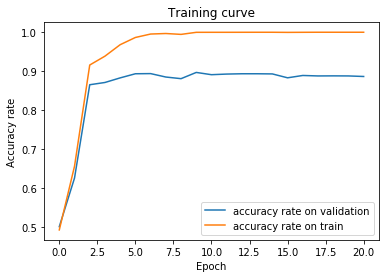

--------------------------Evaluation of Test set------------------------------


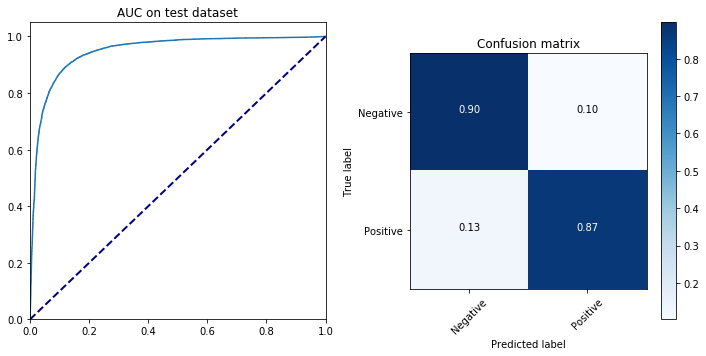

On test dataset: accuracy_rate:  0.88484  AUC:  0.9481752064
--------------------------3 correct and 3 incorrect predictions------------------------------
---------3 correct prediction -------
[("i was n't expecting to much of this movie when i went into the theater but i had been waiting for it for many years to sum it up it was pretty damn     was pretty good i thought he was going to be     wrong  but i was    was also good but the best  has to go     he played the bad  too well i mean he was  sadistic and   the back story between the  was  plus i liked    took  until about 40 minutes into the film it   time to pick the character you wanted to  live and the one you wanted to     was pretty good as the      i liked   kind  cried when he found him dead it was better then  him being    buddy is  who cares it showed how he    overall this was     with some", 1), ('one thing i have   british horror movies from the  is that   hold up     of blood is a case in point as are all     add the 

61  accuracy_rate:  0.8042  auc:  0.8953015200000001
62  accuracy_rate:  0.8208  auc:  0.89243256
63  accuracy_rate:  0.8226  auc:  0.8924188799999999
64  accuracy_rate:  0.8044  auc:  0.8974779199999999
65  accuracy_rate:  0.8154  auc:  0.89803576
66  accuracy_rate:  0.813  auc:  0.88616768
67  accuracy_rate:  0.8222  auc:  0.8971126399999999
68  accuracy_rate:  0.826  auc:  0.89740176
69  accuracy_rate:  0.8264  auc:  0.89763232
70  accuracy_rate:  0.822  auc:  0.8932731999999999
71  accuracy_rate:  0.8212  auc:  0.8956083200000001
72  accuracy_rate:  0.8212  auc:  0.90241264
73  accuracy_rate:  0.8262  auc:  0.89737968
74  accuracy_rate:  0.806  auc:  0.8830004800000002
75  accuracy_rate:  0.8248  auc:  0.90184144
76  accuracy_rate:  0.8264  auc:  0.89640648
77  accuracy_rate:  0.8242  auc:  0.8958991199999999
78  accuracy_rate:  0.831  auc:  0.90188648
79  accuracy_rate:  0.8292  auc:  0.90105088
80  accuracy_rate:  0.8274  auc:  0.8989976
81  accuracy_rate:  0.8306  auc:  0.900312

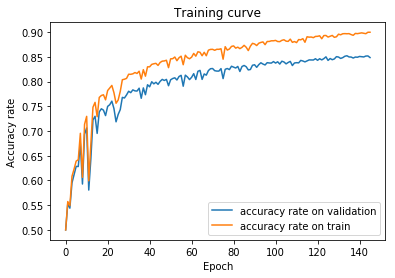

--------------------------Evaluation of Test set------------------------------


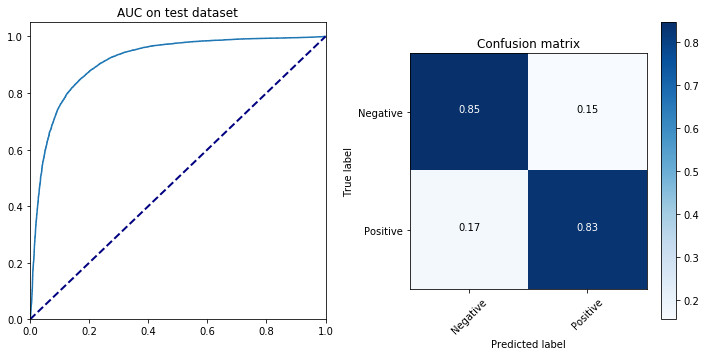

On test dataset: accuracy_rate:  0.83888  AUC:  0.9127369184
--------------------------3 correct and 3 incorrect predictions------------------------------
---------3 correct prediction -------
[("i was n't expecting to much of this movie when i went into the theater but i had been waiting for it for many years to sum it up it was pretty damn     was pretty good i thought he was going to be     wrong  but i was    was also good but the best  has to go     he played the bad  too well i mean he was  sadistic and   the back story between the  was  plus i liked    took  until about 40 minutes into the film it   time to pick the character you wanted to  live and the one you wanted to     was pretty good as the      i liked   kind  cried when he found him dead it was better then  him being    buddy is  who cares it showed how he    overall this was     with some", 1), ('one thing i have   british horror movies from the  is that   hold up     of blood is a case in point as are all     add the 

In [99]:
n_gram_list = [2]
optimizer_list = [torch.optim.Adam, torch.optim.Adagrad]
embedding_dim_list = [50]
min_freq_list = [10]
learning_rate_list = [0.005]
decay_rate_list = [1]
batch_size_list = [32]
weight_decay_list = [0.0]
result = []
for n_gram in n_gram_list:
    for optimizer in optimizer_list:
        for embedding_dim in embedding_dim_list:
            for min_freq in min_freq_list:
                for learning_rate in learning_rate_list:
                    for decay_rate in decay_rate_list:
                         for batch_size in batch_size_list:
                                for weight_decay in weight_decay_list:
                                    model = Processing_and_BOW(bow = BagOfWord, optimizer = optimizer, learning_rate = learning_rate, scheduler = torch.optim.lr_scheduler.LambdaLR,
                                                                decay_rate = decay_rate, batch_size = batch_size ,n_gram= n_gram, min_freq = min_freq, embedding_dim = embedding_dim, 
                                                                weight_decay = weight_decay, early_stopping_rounds = 10,max_epoch = 200)
                                    model.process_file_and_get_vocab()
                                    model.init_model_and_optimizer()
                                    model.train_and_select_model()
                                    model.plot_training_curve()
                                    accuracy_rate, auc = model.eval_on_test_data()
                                    model.show_result_text()
                                    print('---------3 correct prediction -------')
                                    print(model.rightclassified_text[:3])
                                    print('---------3 incorrect prediction -------')
                                    print(model.misclassified_text[:3])
                                    print()
                                    print()
                                    one_result = [model.n_gram, model.embedding_dim, model.min_freq, model.batch_size, model.optimizer_name ,
                                                 model.learning_rate, model.decay_rate, model.weight_decay, model.vocab_size, model.best_epoch,
                                                 accuracy_rate, auc]
                                    result.append(one_result)

In [100]:
result_optimizer = pd.DataFrame(result, columns=header)
result_optimizer.to_csv('./result_optimizer.csv', index=False)
result_optimizer[['n_gram','embedding_dim','min_freq','optimizer_name','learning_rate','best_epoch','accuracy_rate']]

,n_gram,embedding_dim,min_freq,optimizer_name,learning_rate,best_epoch,accuracy_rate
0,2,50,10,Adam,0.005,8,0.88484
1,2,50,10,Adagrad,0.005,133,0.83888


# Learn_rate

 Parameters  n_gram:  2  embedding_dim:  50  min_freq: 10  batch_size:  32  optimizer_name:  Adam  learning rate:  0.1  decay_rate:  1  weight_decay: 0.0
The number of reviews in train:  20000
The number of reviews in validation:  5000
The number of reviews in test:  25000
The vocab size:  53463
The top ten most frequent words: 
[(('of', 'the'), 31280), (('in', 'the'), 19954), (('it', "'s"), 13049), (('this', 'movie'), 12039), (('and', 'the'), 10553), (('is', 'a'), 10548), (('the', 'film'), 10048), (('to', 'the'), 9596), (('to', 'be'), 9403), (('the', 'movie'), 8955), (('this', 'film'), 8293), (('it', 'is'), 8179), (('this', 'is'), 7310), (('it', 'was'), 7269), (('on', 'the'), 7129), (('in', 'a'), 7099), (('do', "n't"), 6517), (('for', 'the'), 6353), (('one', 'of'), 6352), (('with', 'the'), 6290)]
---------------------Accuracy rate and AUC on validation dataset-------------------- 
Before training  accuracy_rate:  0.5008  AUC:  0.51418632
0  accuracy_rate:  0.4906  auc:  0.47156352
1  

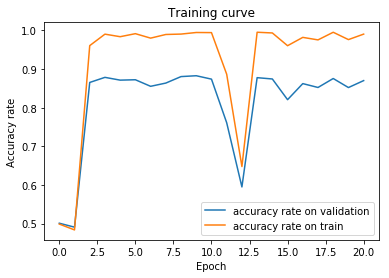

--------------------------Evaluation of Test set------------------------------


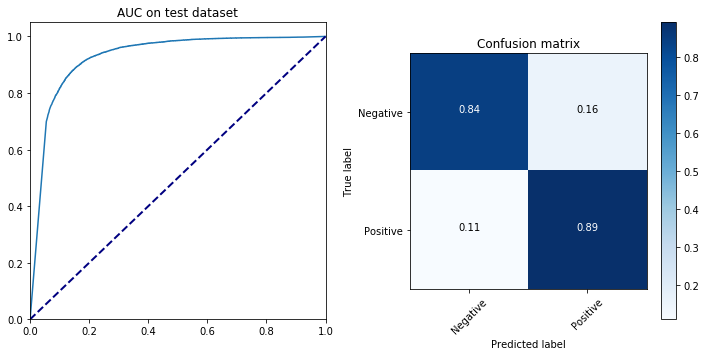

On test dataset: accuracy_rate:  0.86764  AUC:  0.9282193407999999
--------------------------3 correct and 3 incorrect predictions------------------------------
---------3 correct prediction -------
[("i was n't expecting to much of this movie when i went into the theater but i had been waiting for it for many years to sum it up it was pretty damn     was pretty good i thought he was going to be     wrong  but i was    was also good but the best  has to go     he played the bad  too well i mean he was  sadistic and   the back story between the  was  plus i liked    took  until about 40 minutes into the film it   time to pick the character you wanted to  live and the one you wanted to     was pretty good as the      i liked   kind  cried when he found him dead it was better then  him being    buddy is  who cares it showed how he    overall this was     with some", 1), ('one thing i have   british horror movies from the  is that   hold up     of blood is a case in point as are all     ad

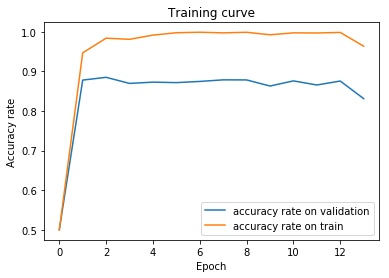

--------------------------Evaluation of Test set------------------------------


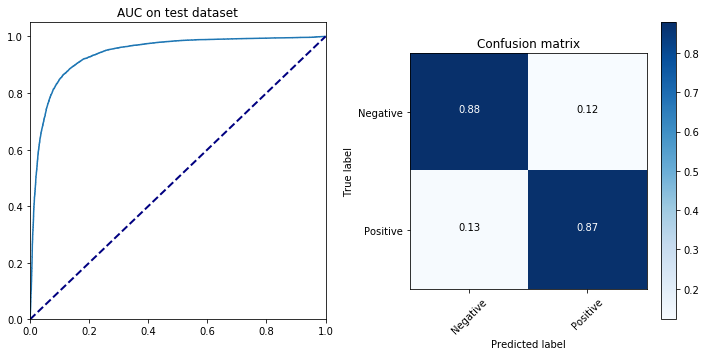

On test dataset: accuracy_rate:  0.87532  AUC:  0.939885088
--------------------------3 correct and 3 incorrect predictions------------------------------
---------3 correct prediction -------
[("i was n't expecting to much of this movie when i went into the theater but i had been waiting for it for many years to sum it up it was pretty damn     was pretty good i thought he was going to be     wrong  but i was    was also good but the best  has to go     he played the bad  too well i mean he was  sadistic and   the back story between the  was  plus i liked    took  until about 40 minutes into the film it   time to pick the character you wanted to  live and the one you wanted to     was pretty good as the      i liked   kind  cried when he found him dead it was better then  him being    buddy is  who cares it showed how he    overall this was     with some", 1), ('one thing i have   british horror movies from the  is that   hold up     of blood is a case in point as are all     add the  

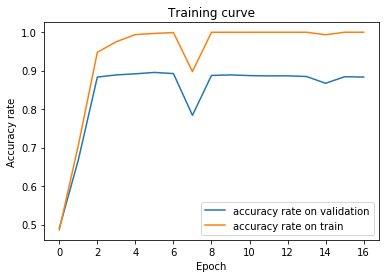

--------------------------Evaluation of Test set------------------------------


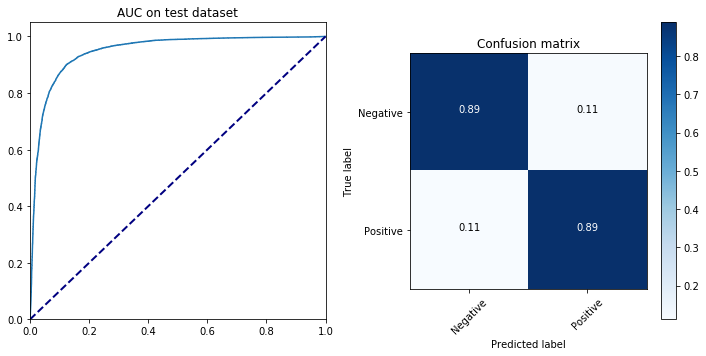

On test dataset: accuracy_rate:  0.88672  AUC:  0.9481161216
--------------------------3 correct and 3 incorrect predictions------------------------------
---------3 correct prediction -------
[("i was n't expecting to much of this movie when i went into the theater but i had been waiting for it for many years to sum it up it was pretty damn     was pretty good i thought he was going to be     wrong  but i was    was also good but the best  has to go     he played the bad  too well i mean he was  sadistic and   the back story between the  was  plus i liked    took  until about 40 minutes into the film it   time to pick the character you wanted to  live and the one you wanted to     was pretty good as the      i liked   kind  cried when he found him dead it was better then  him being    buddy is  who cares it showed how he    overall this was     with some", 1), ('i think this is one   top   along    and   boogie     he also directed this one so he had a talent for that  like his  clint

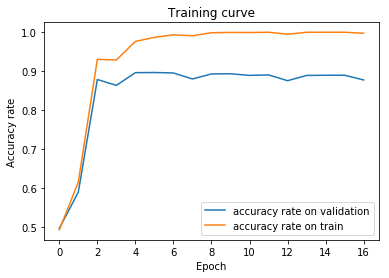

--------------------------Evaluation of Test set------------------------------


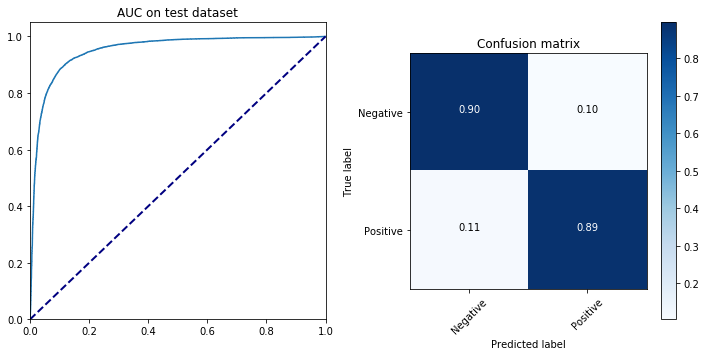

On test dataset: accuracy_rate:  0.89124  AUC:  0.9511162848
--------------------------3 correct and 3 incorrect predictions------------------------------
---------3 correct prediction -------
[("i was n't expecting to much of this movie when i went into the theater but i had been waiting for it for many years to sum it up it was pretty damn     was pretty good i thought he was going to be     wrong  but i was    was also good but the best  has to go     he played the bad  too well i mean he was  sadistic and   the back story between the  was  plus i liked    took  until about 40 minutes into the film it   time to pick the character you wanted to  live and the one you wanted to     was pretty good as the      i liked   kind  cried when he found him dead it was better then  him being    buddy is  who cares it showed how he    overall this was     with some", 1), ('one thing i have   british horror movies from the  is that   hold up     of blood is a case in point as are all     add the 

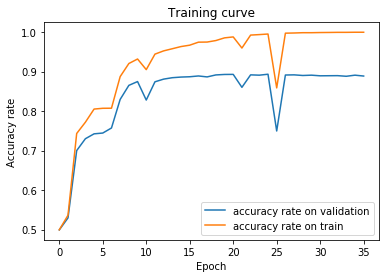

--------------------------Evaluation of Test set------------------------------


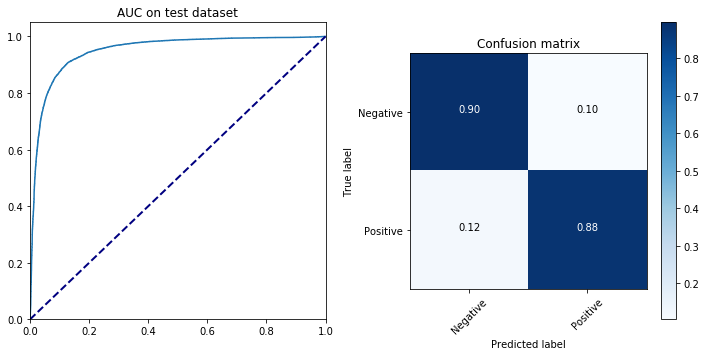

On test dataset: accuracy_rate:  0.88808  AUC:  0.9493961823999999
--------------------------3 correct and 3 incorrect predictions------------------------------
---------3 correct prediction -------
[("i was n't expecting to much of this movie when i went into the theater but i had been waiting for it for many years to sum it up it was pretty damn     was pretty good i thought he was going to be     wrong  but i was    was also good but the best  has to go     he played the bad  too well i mean he was  sadistic and   the back story between the  was  plus i liked    took  until about 40 minutes into the film it   time to pick the character you wanted to  live and the one you wanted to     was pretty good as the      i liked   kind  cried when he found him dead it was better then  him being    buddy is  who cares it showed how he    overall this was     with some", 1), ('i think this is one   top   along    and   boogie     he also directed this one so he had a talent for that  like his 

In [82]:
n_gram_list = [2]
optimizer_list = [torch.optim.Adam]
embedding_dim_list = [50]
min_freq_list = [10]
learning_rate_list = [0.1, 0.05, 0.01, 0.005, 0.001]
decay_rate_list = [1]
batch_size_list = [32]
weight_decay_list = [0.0]
result = []
for n_gram in n_gram_list:
    for optimizer in optimizer_list:
        for embedding_dim in embedding_dim_list:
            for min_freq in min_freq_list:
                for learning_rate in learning_rate_list:
                    for decay_rate in decay_rate_list:
                         for batch_size in batch_size_list:
                                for weight_decay in weight_decay_list:
                                    model = Processing_and_BOW(bow = BagOfWord, optimizer = optimizer, learning_rate = learning_rate, scheduler = torch.optim.lr_scheduler.LambdaLR,
                                                                decay_rate = decay_rate, batch_size = batch_size ,n_gram= n_gram, min_freq = min_freq, embedding_dim = embedding_dim, 
                                                                weight_decay = weight_decay, early_stopping_rounds = 10)
                                    model.process_file_and_get_vocab()
                                    model.init_model_and_optimizer()
                                    model.train_and_select_model()
                                    model.plot_training_curve()
                                    accuracy_rate, auc = model.eval_on_test_data()
                                    model.show_result_text()
                                    print('---------3 correct prediction -------')
                                    print(model.rightclassified_text[:3])
                                    print('---------3 incorrect prediction -------')
                                    print(model.misclassified_text[:3])
                                    print()
                                    print()
                                    one_result = [model.n_gram, model.embedding_dim, model.min_freq, model.batch_size, model.optimizer_name ,
                                                 model.learning_rate, model.decay_rate, model.weight_decay, model.vocab_size, model.best_epoch,
                                                 accuracy_rate, auc]
                                    result.append(one_result)

In [92]:
#result_learn_rate = pd.DataFrame(result, columns=header)
result_learn_rate.to_csv('./result_learn_rate.csv', index=False)
result_learn_rate[['n_gram','embedding_dim','min_freq','optimizer_name','learning_rate','best_epoch','accuracy_rate']]

,n_gram,embedding_dim,min_freq,optimizer_name,learning_rate,best_epoch,accuracy_rate
0,2,50,10,Adam,0.100,8,0.86764
1,2,50,10,Adam,0.050,1,0.87532
2,2,50,10,Adam,0.010,4,0.88672
3,2,50,10,Adam,0.005,4,0.89124
4,2,50,10,Adam,0.001,23,0.88808


# Decay

 Parameters  n_gram:  2  embedding_dim:  50  min_freq: 10  batch_size:  32  optimizer_name:  Adam  learning rate:  0.005  decay_rate:  1  weight_decay: 0.0
The number of reviews in train:  20000
The number of reviews in validation:  5000
The number of reviews in test:  25000
The vocab size:  53463
The top ten most frequent words: 
[(('of', 'the'), 31280), (('in', 'the'), 19954), (('it', "'s"), 13049), (('this', 'movie'), 12039), (('and', 'the'), 10553), (('is', 'a'), 10548), (('the', 'film'), 10048), (('to', 'the'), 9596), (('to', 'be'), 9403), (('the', 'movie'), 8955), (('this', 'film'), 8293), (('it', 'is'), 8179), (('this', 'is'), 7310), (('it', 'was'), 7269), (('on', 'the'), 7129), (('in', 'a'), 7099), (('do', "n't"), 6517), (('for', 'the'), 6353), (('one', 'of'), 6352), (('with', 'the'), 6290)]
---------------------Accuracy rate and AUC on validation dataset-------------------- 
Before training  accuracy_rate:  0.4994  AUC:  0.48976008
0  accuracy_rate:  0.656  auc:  0.77094816
1 

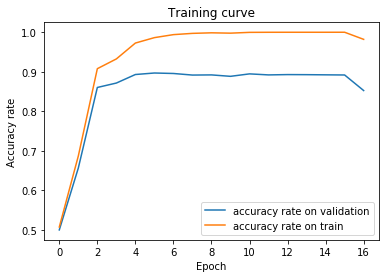

--------------------------Evaluation of Test set------------------------------


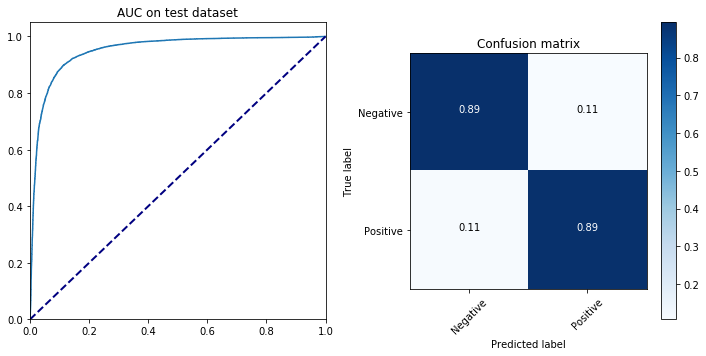

On test dataset: accuracy_rate:  0.89152  AUC:  0.9511405792
--------------------------3 correct and 3 incorrect predictions------------------------------
---------3 correct prediction -------
[("i was n't expecting to much of this movie when i went into the theater but i had been waiting for it for many years to sum it up it was pretty damn     was pretty good i thought he was going to be     wrong  but i was    was also good but the best  has to go     he played the bad  too well i mean he was  sadistic and   the back story between the  was  plus i liked    took  until about 40 minutes into the film it   time to pick the character you wanted to  live and the one you wanted to     was pretty good as the      i liked   kind  cried when he found him dead it was better then  him being    buddy is  who cares it showed how he    overall this was     with some", 1), ('one thing i have   british horror movies from the  is that   hold up     of blood is a case in point as are all     add the 

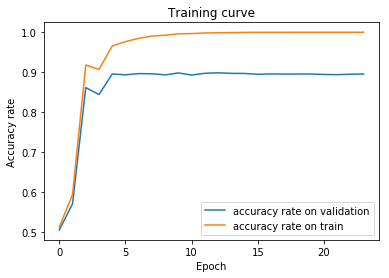

--------------------------Evaluation of Test set------------------------------


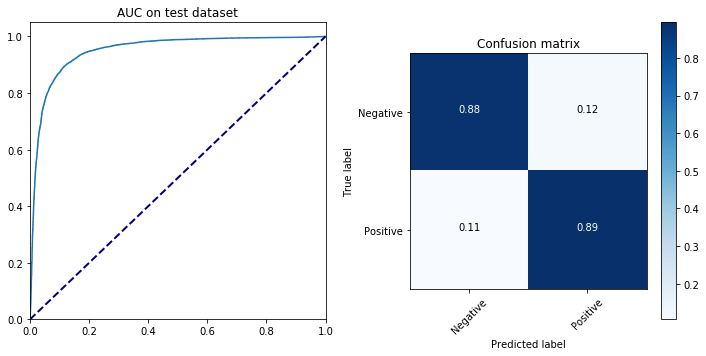

On test dataset: accuracy_rate:  0.88916  AUC:  0.9497072223999999
--------------------------3 correct and 3 incorrect predictions------------------------------
---------3 correct prediction -------
[("i was n't expecting to much of this movie when i went into the theater but i had been waiting for it for many years to sum it up it was pretty damn     was pretty good i thought he was going to be     wrong  but i was    was also good but the best  has to go     he played the bad  too well i mean he was  sadistic and   the back story between the  was  plus i liked    took  until about 40 minutes into the film it   time to pick the character you wanted to  live and the one you wanted to     was pretty good as the      i liked   kind  cried when he found him dead it was better then  him being    buddy is  who cares it showed how he    overall this was     with some", 1), ('one thing i have   british horror movies from the  is that   hold up     of blood is a case in point as are all     ad

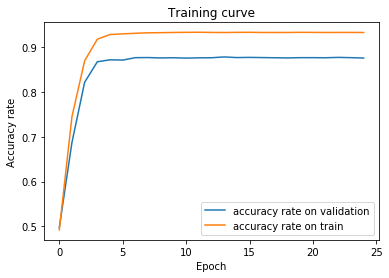

--------------------------Evaluation of Test set------------------------------


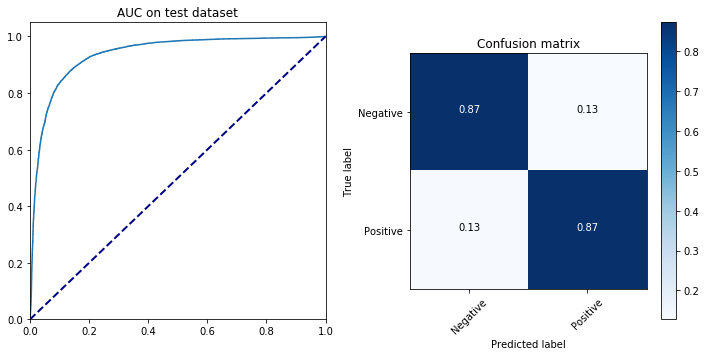

On test dataset: accuracy_rate:  0.87004  AUC:  0.9372529535999999
--------------------------3 correct and 3 incorrect predictions------------------------------
---------3 correct prediction -------
[("i was n't expecting to much of this movie when i went into the theater but i had been waiting for it for many years to sum it up it was pretty damn     was pretty good i thought he was going to be     wrong  but i was    was also good but the best  has to go     he played the bad  too well i mean he was  sadistic and   the back story between the  was  plus i liked    took  until about 40 minutes into the film it   time to pick the character you wanted to  live and the one you wanted to     was pretty good as the      i liked   kind  cried when he found him dead it was better then  him being    buddy is  who cares it showed how he    overall this was     with some", 1), ('one thing i have   british horror movies from the  is that   hold up     of blood is a case in point as are all     ad

In [93]:
n_gram_list = [2]
optimizer_list = [torch.optim.Adam]
embedding_dim_list = [50]
min_freq_list = [10]
learning_rate_list = [0.005]
decay_rate_list = [1, 0.9, 0.5]
batch_size_list = [32]
weight_decay_list = [0.0]
result = []
for n_gram in n_gram_list:
    for optimizer in optimizer_list:
        for embedding_dim in embedding_dim_list:
            for min_freq in min_freq_list:
                for learning_rate in learning_rate_list:
                    for decay_rate in decay_rate_list:
                         for batch_size in batch_size_list:
                                for weight_decay in weight_decay_list:
                                    model = Processing_and_BOW(bow = BagOfWord, optimizer = optimizer, learning_rate = learning_rate, scheduler = torch.optim.lr_scheduler.LambdaLR,
                                                                decay_rate = decay_rate, batch_size = batch_size ,n_gram= n_gram, min_freq = min_freq, embedding_dim = embedding_dim, 
                                                                weight_decay = weight_decay, early_stopping_rounds = 10)
                                    model.process_file_and_get_vocab()
                                    model.init_model_and_optimizer()
                                    model.train_and_select_model()
                                    model.plot_training_curve()
                                    accuracy_rate, auc = model.eval_on_test_data()
                                    model.show_result_text()
                                    print('---------3 correct prediction -------')
                                    print(model.rightclassified_text[:3])
                                    print('---------3 incorrect prediction -------')
                                    print(model.misclassified_text[:3])
                                    print()
                                    print()
                                    one_result = [model.n_gram, model.embedding_dim, model.min_freq, model.batch_size, model.optimizer_name ,
                                                 model.learning_rate, model.decay_rate, model.weight_decay, model.vocab_size, model.best_epoch,
                                                 accuracy_rate, auc]
                                    result.append(one_result)

In [96]:
#result_decay_rate = pd.DataFrame(result, columns=header)
#result_decay_rate.to_csv('./result_decay_rate.csv', index=False)
result_decay_rate[['n_gram','embedding_dim','decay_rate','optimizer_name','learning_rate','best_epoch','accuracy_rate']]

,n_gram,embedding_dim,decay_rate,optimizer_name,learning_rate,best_epoch,accuracy_rate
0,2,50,1.0,Adam,0.005,4,0.89152
1,2,50,0.9,Adam,0.005,11,0.88916
2,2,50,0.5,Adam,0.005,12,0.87004


# MultiClass

In [16]:
train_pos_file_path = '../aclImdb/train/pos/'
train_pos_file_name = [file_name for file_name in os.listdir(train_pos_file_path) if re.findall('^[0-9]+_[0-9]+\.txt$',file_name)]

train_neg_file_path = '../aclImdb/train/neg/'
train_neg_file_name = [file_name for file_name in os.listdir(train_neg_file_path) if re.findall('^[0-9]+_[0-9]+\.txt$',file_name)]

train_pos_file_path_list = [train_pos_file_path + file_path for file_path in train_pos_file_name if check_exist_and_empty(train_pos_file_path + file_path)]
train_neg_file_path_list = [train_neg_file_path + file_path for file_path in train_neg_file_name if check_exist_and_empty(train_neg_file_path + file_path)]


train_dataset = []
for file_path in train_pos_file_path_list:
    score = int(file_path.split('_')[1].split('.')[0])
    train_dataset.append([tokenizer(open(file_path,'r').read()),score - 1])

for file_path in train_neg_file_path_list:
    score = int(file_path.split('_')[1].split('.')[0])
    train_dataset.append([tokenizer(open(file_path,'r').read()),score - 1])


In [17]:
pd.DataFrame(train_dataset, columns=['text','label']).to_csv('../aclImdb/data/train_score.csv',header=False,index=False)

In [18]:
test_pos_file_path = '../aclImdb/test/pos/'
test_pos_file_name = [file_name for file_name in os.listdir(test_pos_file_path) if re.findall('^[0-9]+_[0-9]+\.txt$',file_name)]

test_neg_file_path = '../aclImdb/test/neg/'
test_neg_file_name = [file_name for file_name in os.listdir(test_neg_file_path) if re.findall('^[0-9]+_[0-9]+\.txt$',file_name)]

test_pos_file_path_list = [test_pos_file_path + file_path for file_path in test_pos_file_name if check_exist_and_empty(test_pos_file_path + file_path)]
test_neg_file_path_list = [test_neg_file_path + file_path for file_path in test_neg_file_name if check_exist_and_empty(test_neg_file_path + file_path)]


test_dataset = []
for file_path in test_pos_file_path_list:
    score = int(file_path.split('_')[1].split('.')[0])
    test_dataset.append([tokenizer(open(file_path,'r').read()),score - 1])

for file_path in test_neg_file_path_list:
    score = int(file_path.split('_')[1].split('.')[0])
    test_dataset.append([tokenizer(open(file_path,'r').read()),score - 1])


In [19]:
pd.DataFrame(test_dataset, columns=['text','label']).to_csv('../aclImdb/data/test_score.csv',header=False,index=False)

In [114]:
class BagOfWord(torch.nn.Module):
    
    def __init__(self, vocab_len, word_vector_dim):
        super().__init__()
        self.word_vector_dim = word_vector_dim
        self.vocab_len = vocab_len
        self.embedding = torch.nn.Embedding(self.vocab_len,self.word_vector_dim)
        self.linear = torch.nn.Linear(self.word_vector_dim,10)
        #self.linear_1 = torch.nn.Linear(50,10)
        
    def forward(self,X):
        sentence_length = (X>1).sum(0).unsqueeze(dim=1)
        sentence_length[sentence_length < 1] = 1
        sentence_length = sentence_length.float().cuda()
        X = self.embedding(X)
        X = X.sum(dim = 0)
        X = X/sentence_length
        out = self.linear(X)
        #out = self.linear_1(out)
        return out
    
    

class Processing_and_BOW():
    
    def __init__(self, bow, optimizer, learning_rate, scheduler, decay_rate, batch_size = 32 ,n_gram=1, min_freq = 1, embedding_dim = 100, 
                 train_file_path = '../aclImdb/data/train_score.csv', test_file_path= '../aclImdb/data/test_score.csv', weight_decay = 0.0, 
                 max_epoch = 50, early_stopping_rounds = 10):
        
        self.model = bow
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.scheduler = scheduler
        self.decay_rate = decay_rate
        self.n_gram = n_gram
        self.min_freq = min_freq
        self.embedding_dim = embedding_dim
        self.train_file_path = train_file_path
        self.test_file_path = test_file_path
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.max_epoch = max_epoch
        self.early_stopping_rounds = early_stopping_rounds
        
        
    def n_bag_of_word(self, x):
        if len(x) <= self.n_gram:
            return [tuple(x)]
        else:
            result = []
            for i in range(0,len(x) - self.n_gram + 1):
                result.append(tuple(x[i:i+self.n_gram]))
            return result
    
    
    def process_file_and_get_vocab(self):
        TEXT = torchtext.data.Field(preprocessing = self.n_bag_of_word)
        LABEL = torchtext.data.Field(sequential = False, use_vocab = False)
        
        TEST_TEXT = torchtext.data.Field(preprocessing = self.n_bag_of_word)
        
        self.train,self.validation = torchtext.data.TabularDataset(self.train_file_path,format='csv',
                              fields=[('text',TEXT),('label',LABEL)]).split(split_ratio=0.8, stratified=True,
                                                                            strata_field='label', 
                                                                            random_state= random.getstate())
        
        self.test = torchtext.data.TabularDataset(self.test_file_path, format='csv',
                              fields=[('text',TEST_TEXT),('label',LABEL)])
        
        TEXT.build_vocab(self.train,min_freq=self.min_freq)
        TEST_TEXT.vocab = TEXT.vocab
        
        
        self.train_iter = torchtext.data.BucketIterator(self.train, batch_size=self.batch_size, sort_key = lambda x: len(x.Text),
                                                       repeat=False, shuffle=True, device=0)
        self.validation_iter = torchtext.data.BucketIterator(self.validation, batch_size=self.batch_size, sort_key = lambda x: len(x.Text),
                                                       repeat=False, shuffle=True, device=0)
        self.test_iter = torchtext.data.BucketIterator(self.test, batch_size=self.batch_size, sort_key = lambda x: len(x.Text),
                                                       repeat=False, shuffle=True, device=0)
        
        print('The number of reviews in train: ', len(self.train.examples))
        print('The number of reviews in validation: ', len(self.validation.examples))
        print('The number of reviews in test: ', len(self.test.examples))
        print('N-grame: ', self.n_gram)
        print('The vocab size: ', len(self.train.fields['text'].vocab.itos))
        print('The top ten most frequent words: ')
        print(sorted(self.train.fields['text'].vocab.freqs.items(), key= lambda a : a[1], reverse=True)[:20])
        
    
    
    def init_model_and_optimizer(self):
        self.model = self.model(vocab_len = len(self.train.fields['text'].vocab.itos),
                                word_vector_dim = self.embedding_dim).cuda()
        self.optimizer = self.optimizer([p for p in self.model.parameters() if p.requires_grad], lr = self.learning_rate, 
                                        weight_decay = self.weight_decay)
        self.scheduler = self.scheduler(self.optimizer, lambda epoch: self.decay_rate ** epoch)
    
    
    
    def train_model(self):
        self.model.train()
        for batch in self.train_iter:
            self.optimizer.zero_grad()
            text,label = batch.text,batch.label
            out = self.model(text)
            loss = torch.nn.functional.cross_entropy(out, label)
            loss.backward()
            self.optimizer.step()
    
    
    
    def eval_model(self,model,data_iter, is_draw = False):
        
        model.eval()
        predict = []
        target = []
        for batch in data_iter:
            text,label = batch.text,batch.label
            out = self.model(text)
            
            predict.extend(list(torch.argmax(out, dim=1).cpu().numpy()))
            target.extend(list(label.cpu().detach().numpy()))
        predict = np.array(predict)
        target = np.array(target)
        
        if is_draw:
            cnf_matrix = confusion_matrix(target, predict, labels = [0,1,2,3,4,5,6,7,8,9])
            f, ax1 = plt.subplots(1, 1)
            f.set_figheight(8)
            f.set_figwidth(8)
            
            self.plot_confusion_matrix(cnf_matrix, [0,1,2,3,4,5,6,7,8,9], ax1, normalize = True,
                                  title='Confusion matrix')
        return sum(predict == target)/len(target)
        
    
    def train_and_select_model(self):
        print('---------------------Accuracy rate on validation dataset-------------------- ')
        print('Before training: ',self.eval_model(self.model, self.validation_iter))
        self.eval_on_val_accuracy_rate = []
        best_accuracy = 0.0
        best_epoch = -1
        for epoch in range(self.max_epoch):
            self.scheduler.step()
            self.train_model()
            accuracy_rate = self.eval_model(self.model, self.validation_iter)
            self.eval_on_val_accuracy_rate.append(accuracy_rate)
            print(epoch,accuracy_rate)
            if accuracy_rate > best_accuracy:
                self.best_model = copy.deepcopy(self.model)
                best_accuracy = accuracy_rate
                best_epoch = epoch
            if epoch - best_epoch > self.early_stopping_rounds:
                break
        print('''Training process end, the best model was picked when epoch = ', best_epoch, ' with the best
         accuracy rate on validation dataset: ''',best_accuracy, ' and accuracy rate on training dataset: ',
             self.eval_model(self.best_model, self.train_iter)) 
            
            
    def eval_on_test_data(self):
        accuracy_rate = self.eval_model(self.best_model, self.test_iter, is_draw = True)
        return accuracy_rate
    
    def plot_confusion_matrix(self, cm, classes,ax2,
                          normalize=False,
                          title='Confusion matrix on Test dataset',
                          cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


        img = ax2.imshow(cm, interpolation='nearest', cmap=cmap)
        ax2.set_title(title)
        plt.colorbar(img)
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            ax2.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        ax2.set_ylabel('True label')
        ax2.set_xlabel('Predicted label')
        plt.tight_layout()
        plt.show()

The number of reviews in train:  20000
The number of reviews in validation:  5000
The number of reviews in test:  25000
N-grame:  2
The vocab size:  53811
The top ten most frequent words: 
[(('of', 'the'), 31310), (('in', 'the'), 19965), (('it', "'s"), 13059), (('this', 'movie'), 12040), (('and', 'the'), 10614), (('is', 'a'), 10549), (('the', 'film'), 10107), (('to', 'the'), 9612), (('to', 'be'), 9477), (('the', 'movie'), 8944), (('this', 'film'), 8307), (('it', 'is'), 8207), (('this', 'is'), 7303), (('it', 'was'), 7203), (('on', 'the'), 7126), (('in', 'a'), 7106), (('do', "n't"), 6539), (('for', 'the'), 6392), (('one', 'of'), 6362), (('of', 'a'), 6294)]
---------------------Accuracy rate on validation dataset-------------------- 
Before training:  0.1158
0 0.1764
1 0.2732
2 0.3564
3 0.3804
4 0.36
5 0.4138
6 0.4128
7 0.398
8 0.4314
9 0.4146
10 0.4232
11 0.411
12 0.3898
13 0.4184
14 0.4036
Training process end, the best model was picked when epoch = ', best_epoch, ' with the best
      

/Users/qintai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:173: RuntimeWarning: invalid value encountered in true_divide
/Users/qintai/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


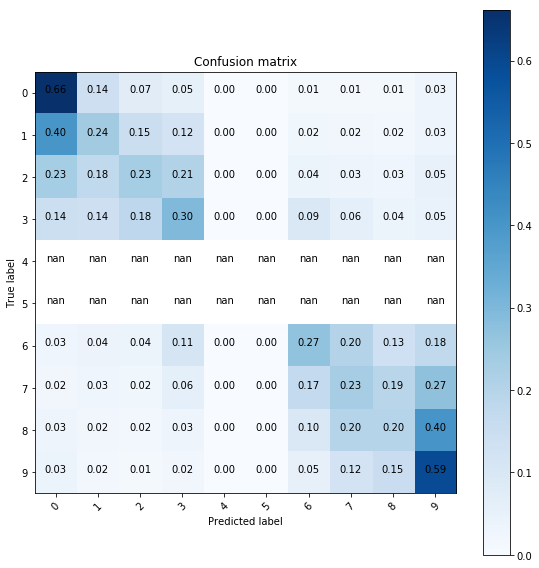

0.39756

In [115]:
model = Processing_and_BOW(bow=BagOfWord, optimizer=torch.optim.Adam, learning_rate=0.005, scheduler= torch.optim.lr_scheduler.LambdaLR,
                  decay_rate = 0.95, embedding_dim = 50, weight_decay = 0, n_gram = 2, min_freq = 10, early_stopping_rounds = 5)
model.process_file_and_get_vocab()
model.init_model_and_optimizer()
model.train_and_select_model()
model.eval_on_test_data()